Based on [Qiskit textbook](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html) tutorial.

# Step -1.

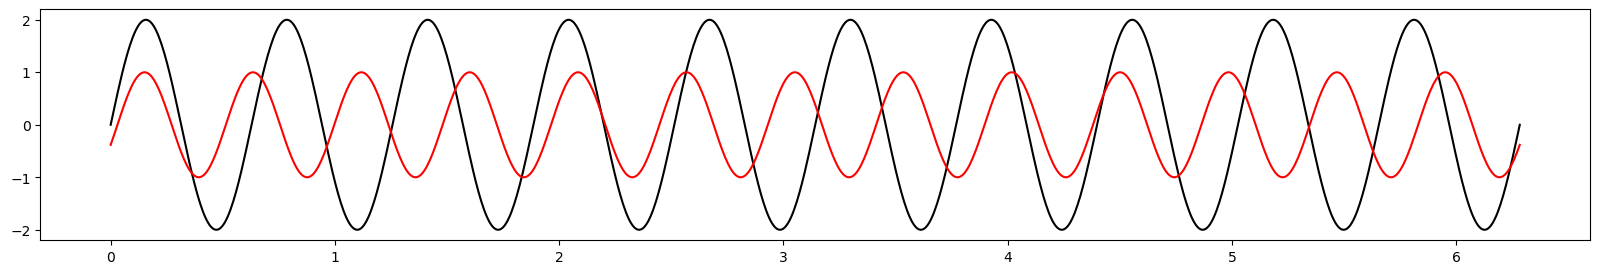

In [26]:
import numpy as np
import matplotlib.pyplot as plt

ticks = np.linspace(0.0, np.pi * 2, 1024)
wave1 = 2 * np.sin(ticks * 10) # 10 Hz
wave2 = np.sin(ticks * 13 - np.pi / 8) # 13 Hz
plt.figure(figsize=(20, 3))
plt.plot(ticks, wave1, c='black')
plt.plot(ticks, wave2, c='red')

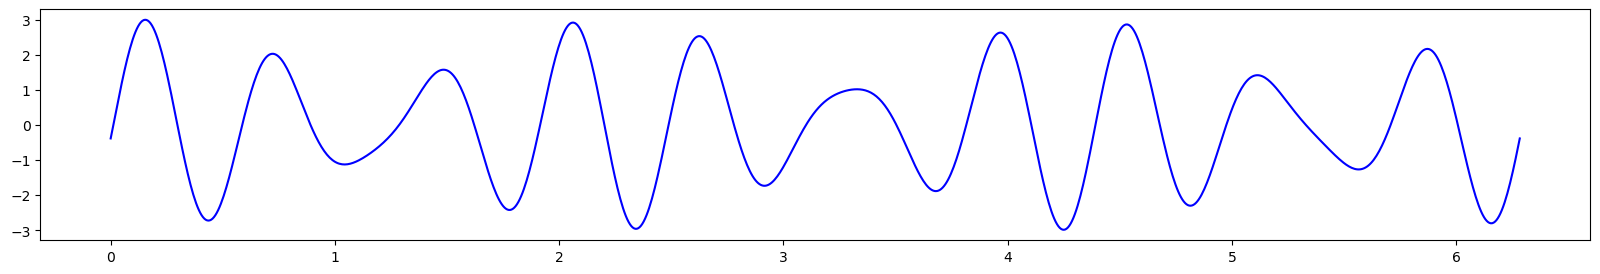

In [27]:
waves = wave1 + wave2
plt.figure(figsize=(20, 3))
plt.plot(ticks, waves, c='blue')

<BarContainer object of 20 artists>

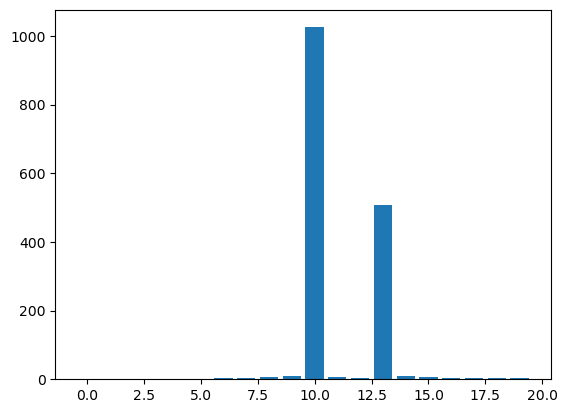

In [36]:
from scipy.fft import fft
from scipy.linalg import dft
amplitudes = fft(waves)
positives = amplitudes[:len(amplitudes) // 2]
negatives = amplitudes[len(amplitudes) // 2:]

plt.bar(range(20), abs(positives)[:20])

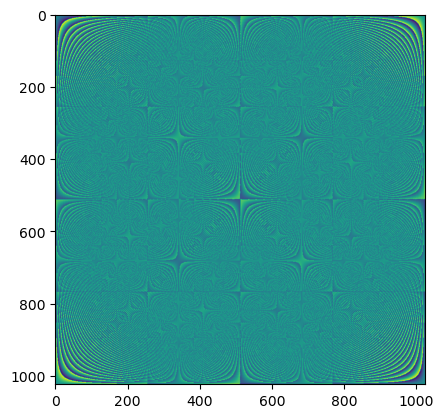

In [40]:
FTMATRIX = dft(1024)
import cmath
plt.imshow(np.vectorize(cmath.phase)(FTMATRIX))

# QFT

QFT is contructed of $H$ and $CROT_k$ -- controlled rotation around $Z$ axis by $e^\frac{2\pi i}{2^{k}}$. Or, simpler, by $\frac{1}{2^k}$'th of the whole circle. 

Idealogically, to implement QFT of $|\psi\rangle$, we need to rotate each $k$-th qubit by $\frac{\psi}{2^k}$ of the circle, where $\psi$ is binary number representated by the state (e.g. $|0101\rangle$ represents $0101_2=5_{10}$). 

Thus in terms of implementation, for each qubit starting from least significant we:
1. Apply $H$ to prepare $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$.
2. Apply controlled rotation in a binary form. i.e. we rotate $i$-th qubit controlled by $i+1, i+2,.., i+k$'th qubit at the $\frac{1}{2^k}$'th fraction of the circle, or simply $CROT_k(i+k, i)$.

Resulting state is giving a DFT of input amplitude-encoded vector in the reverse order. Thus, we apply $SWAP$ gates to $(1, N)$, $(2, N-1)$, ...

## Step 0. Get the $CROT_k$ gate

Refer to [qiskit implementation if needed](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html#8.-Qiskit-Implementation).

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [2]:
from qiskit.circuit.library import PhaseGate
import math

def get_urot(k):
    # todo: return Controlled-Phase gate for k.
    p = None
    
    return p

This is what we can do with these rotations.

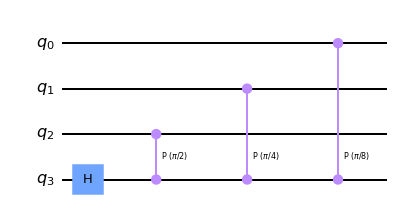

In [17]:
qc = QuantumCircuit(4)
qc.h(3)
qc.append(get_urot(1), [2, 3])
qc.append(get_urot(2), [1, 3])
qc.append(get_urot(3), [0, 3])
qc.draw(output='mpl')

### Step 1. Build a subcircuit to setup a single qubit

![](https://qiskit.org/textbook/ch-algorithms/images/qft.png)

Create a circuit, which, given $i$ for a manipulated qubit's number. It should create all necessary rotations as per image.

NB:
- use **inverse qubit order** to obtain correct result in measurement! What is `i` on the pic is `n - i - 1` in the code. In the schema this will be mirrored.
- `CPhase` is bidirectional, thus argument order is optional.

In [18]:
def get_rotator(n):
    qc = QuantumCircuit(n, name=f"ROT")

    # reproduce the part of the circuit, which prepares a rotated qubit
    
    qc.barrier()
    return qc

print(get_rotator(1).draw())
print(get_rotator(5).draw())

     ┌───┐ ░ 
q_0: ┤ H ├─░─
     └───┘ ░ 
                                                ░ 
q_0: ─────────────────────────────────■─────────░─
                                      │         ░ 
q_1: ────────────────────────■────────┼─────────░─
                             │        │         ░ 
q_2: ───────────────■────────┼────────┼─────────░─
                    │        │        │         ░ 
q_3: ──────■────────┼────────┼────────┼─────────░─
     ┌───┐ │P(π/2)  │P(π/4)  │P(π/8)  │P(π/16)  ░ 
q_4: ┤ H ├─■────────■────────■────────■─────────░─
     └───┘                                      ░ 


## Step 3. Composing Rotators

Something like this:

In [19]:
qc = QuantumCircuit(5)

for i in range(5):
    qbs = [5 - k - 1 for k in range(i, 5)]
    rot = get_rotator(5 - i)
    qc.append(rot, qbs)
qc.draw()

┌──────┐┌──────┐┌──────┐┌──────┐┌─────┐
q_0: ┤4     ├┤3     ├┤2     ├┤1     ├┤ ROT ├
     │      ││      ││      ││  ROT │└─────┘
q_1: ┤3     ├┤2     ├┤1 ROT ├┤0     ├───────
     │      ││  ROT ││      │└──────┘       
q_2: ┤2 ROT ├┤1     ├┤0     ├───────────────
     │      ││      │└──────┘               
q_3: ┤1     ├┤0     ├───────────────────────
     │      │└──────┘                       
q_4: ┤0     ├───────────────────────────────
     └──────┘

## Step 4. Swap them all

Implement the method which swaps the qubits $SWAP(1, N)$, $SWAP(2, N-1)$, ...

In [20]:
def get_swapper(n):
    qc = QuantumCircuit(n, name="SWAP")
    
    # TODO write the code, which will swap qubits pairwise
    
    qc.barrier()
    return qc

In [21]:
get_swapper(7).draw()

░ 
q_0: ─X────────░─
      │        ░ 
q_1: ─┼──X─────░─
      │  │     ░ 
q_2: ─┼──┼──X──░─
      │  │  │  ░ 
q_3: ─┼──┼──┼──░─
      │  │  │  ░ 
q_4: ─┼──┼──X──░─
      │  │     ░ 
q_5: ─┼──X─────░─
      │        ░ 
q_6: ─X────────░─
               ░

## Step 5. Summing up

1. Create rotation blocks for each qubit starting with least significant (last, involving the most control).
2. Add swapper gate.

In [22]:
def MyQFT(n):
    qc = QuantumCircuit(n, name="MyQFT")

    # TODO create a QFT circuit
    
    return qc

In [23]:
qc = MyQFT(4)
print(qc.draw())
print(qc.qasm())

     ┌──────┐┌──────┐┌──────┐┌─────┐┌───────┐
q_0: ┤0     ├┤0     ├┤0     ├┤ ROT ├┤0      ├
     │      ││      ││  ROT │└─────┘│       │
q_1: ┤1     ├┤1 ROT ├┤1     ├───────┤1      ├
     │  ROT ││      │└──────┘       │  SWAP │
q_2: ┤2     ├┤2     ├───────────────┤2      ├
     │      │└──────┘               │       │
q_3: ┤3     ├───────────────────────┤3      ├
     └──────┘                       └───────┘
OPENQASM 2.0;
include "qelib1.inc";
gate ROT q0,q1,q2,q3 { h q3; cp(pi/2) q2,q3; cp(pi/4) q1,q3; cp(pi/8) q0,q3; barrier q0,q1,q2,q3; }
gate ROT_2421244798048 q0,q1,q2 { h q2; cp(pi/2) q1,q2; cp(pi/4) q0,q2; barrier q0,q1,q2; }
gate ROT_2421244798576 q0,q1 { h q1; cp(pi/2) q0,q1; barrier q0,q1; }
gate ROT_2421244720848 q0 { h q0; barrier q0; }
gate SWAP q0,q1,q2,q3 { swap q0,q3; swap q1,q2; barrier q0,q1,q2,q3; }
qreg q[4];
ROT q[0],q[1],q[2],q[3];
ROT_2421244798048 q[0],q[1],q[2];
ROT_2421244798576 q[0],q[1];
ROT_2421244720848 q[0];
SWAP q[0],q[1],q[2],q[3];



## Compare to Qiskit implementation

In [24]:
from qiskit.circuit.library import QFT
qc = QFT(4)
print(qc.draw())
qc.draw(output='mpl')
print(qc.qasm())

     ┌──────┐
q_0: ┤0     ├
     │      │
q_1: ┤1     ├
     │  QFT │
q_2: ┤2     ├
     │      │
q_3: ┤3     ├
     └──────┘
OPENQASM 2.0;
include "qelib1.inc";
gate QFT q0,q1,q2,q3 { h q3; cp(pi/2) q3,q2; cp(pi/4) q3,q1; cp(pi/8) q3,q0; h q2; cp(pi/2) q2,q1; cp(pi/4) q2,q0; h q1; cp(pi/2) q1,q0; h q0; swap q0,q3; swap q1,q2; }
qreg q[4];
QFT q[0],q[1],q[2],q[3];



## Validate with code

Let's start with signal generation and FFT.

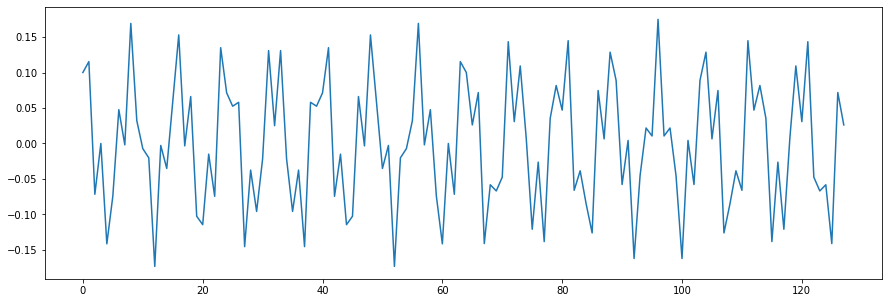

In [25]:
import numpy as np
from math import pi, cos, sin

NQ = 7
N = 2 ** NQ

# freqencies and corresponding amplitudes
freqs = [16, 51]
amps = [8, 6]
state = [0.0] * N


for j, (freq, amp) in enumerate(zip(freqs, amps)):
    # let's make a phase shift to show FFT encodes it in complex argument
    f = cos if j % 2 == 0 else sin
    for i in range(N):
        state[i] += f(2 * pi * i * freq / N) * amp
        
# vector should be normed for QRegister initialization
norm = sum([abs(i) ** 2 for i in state]) ** .5
state_normed = np.array([x / norm for x in state])
plt.figure(figsize=(15, 5))
plt.plot(state_normed)

Before you run, just note that DFT will return **symmetric graph** for amplitude-encoded signal. The reason is justified [in this answer](https://dsp.stackexchange.com/a/4827) (short - $e^{i\phi}$ and $e^{i(-\phi)}$ has different imaginary component, but correspont to the same real-valued harmonic)

F = 16 Hz, A = 6.4 + (-0.0j)
F = 51 Hz, A = -0.0 + (-4.8j)
F = 77 Hz, A = -0.0 + (4.8j)
F = 112 Hz, A = 6.4 + (0.0j)


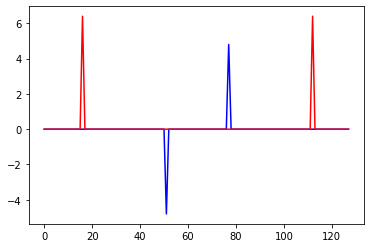

In [26]:
from scipy.fft import fft
import numpy as np

spectrum = fft(state_normed)
for i, v in enumerate(spectrum):
    if abs(v) > 0.1:
        print(f"F = {i} Hz, A = {v.real:.1f} + ({v.imag:.1f}j)")
plt.plot(np.imag(spectrum), 'b')
plt.plot(np.real(spectrum), 'r')

`TODO`: initialize with `state_normed`, then apply `MyQFT`.

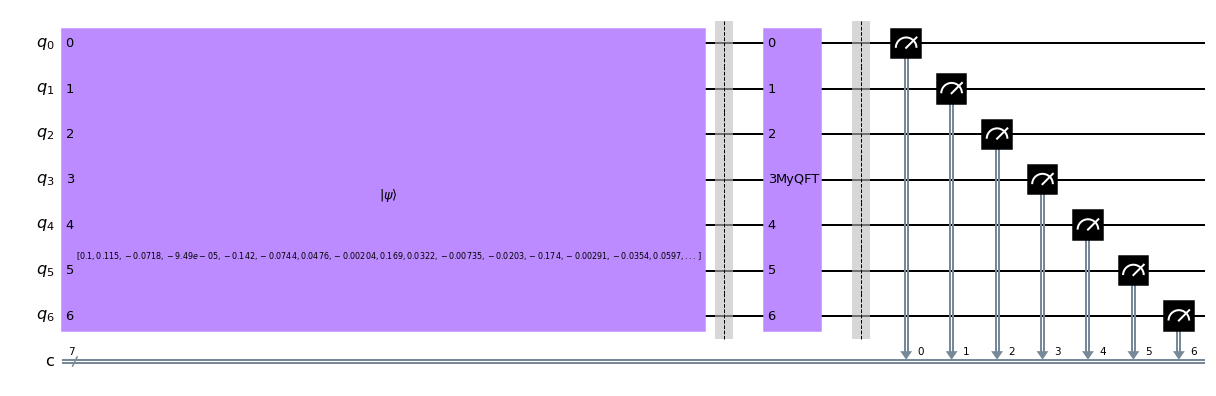

In [27]:
qc = QuantumCircuit(NQ, NQ)

# TODO

qc.draw(output='mpl')

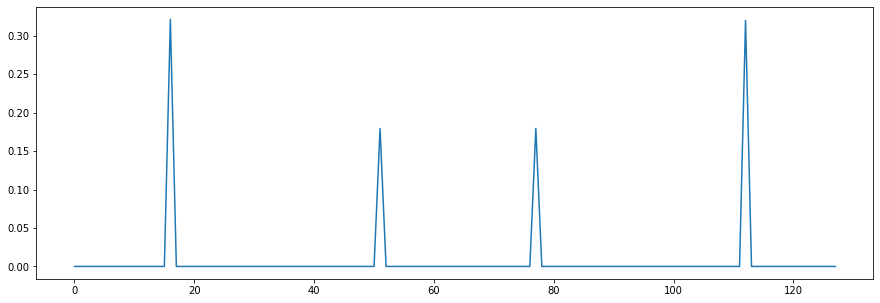

In [28]:
shots = 500000
job = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(qc)
result = [0.0] * N
for key in counts:
    i = int(key, base=2)
    # probabilities
    result[i] = counts[key] / shots
    
plt.figure(figsize=(15, 5))
plt.plot(result)

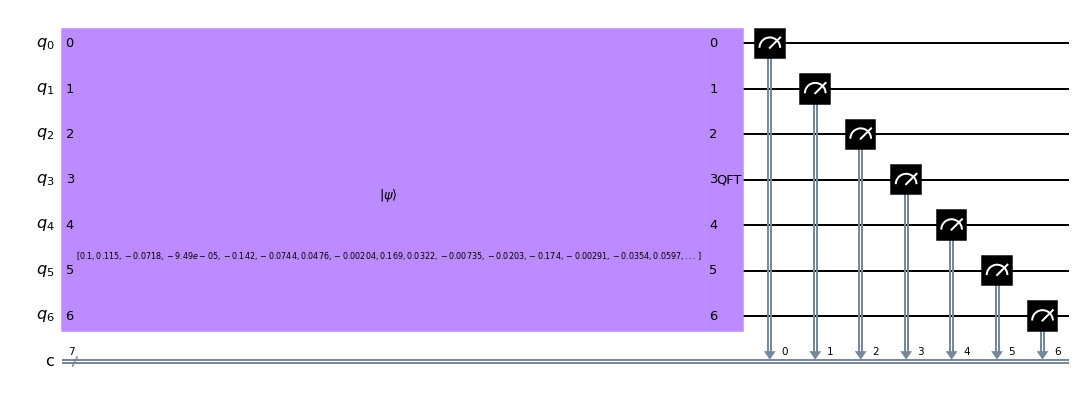

In [15]:
from qiskit.circuit.library import QFT
qc = QuantumCircuit(NQ, NQ)

# repreat the same code for qiskit implementation


qc.draw(output='mpl')

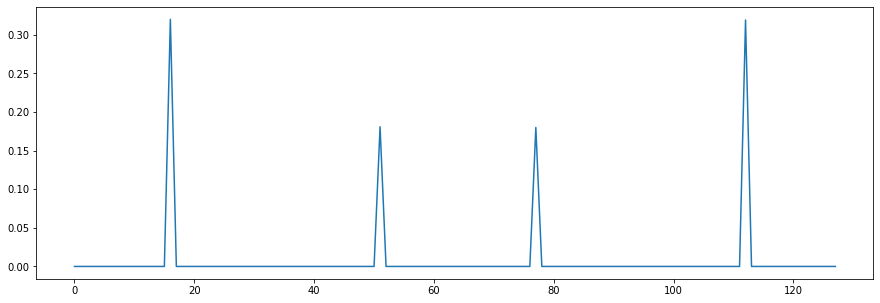

In [29]:
shots = 500000
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(qc)
result = [0.0] * N

for key in counts:
    i = int(key, base=2)
    # probabilities
    result[i] = counts[key] / shots

        
plt.figure(figsize=(15, 5))
plt.plot(result)